Original Notebook: https://www.kaggle.com/pourchot/simple-neural-network

# Simple Neural Networks - Modifications

In this notebook, we will evaluate the performance of a slightly modified version of  the Neural Network presented in the notebook https://www.kaggle.com/pourchot/simple-neural-network. Hyperparameters tuning did not improved the performance on the train set nor the estimated score on test set. We tried to modify the architecture, first by adding a second convolutional layer with the same parameters as the first one, second by adding another dense layer and residual connections before the softmax layer. None of these modifications improved the score. Finally, we manage to _slightly_ improved the estimated test score by modifying the residual connections. The skip connections are added between each dense layer, before the dropout. No connections are bypassing more than one layer (cf. figure).

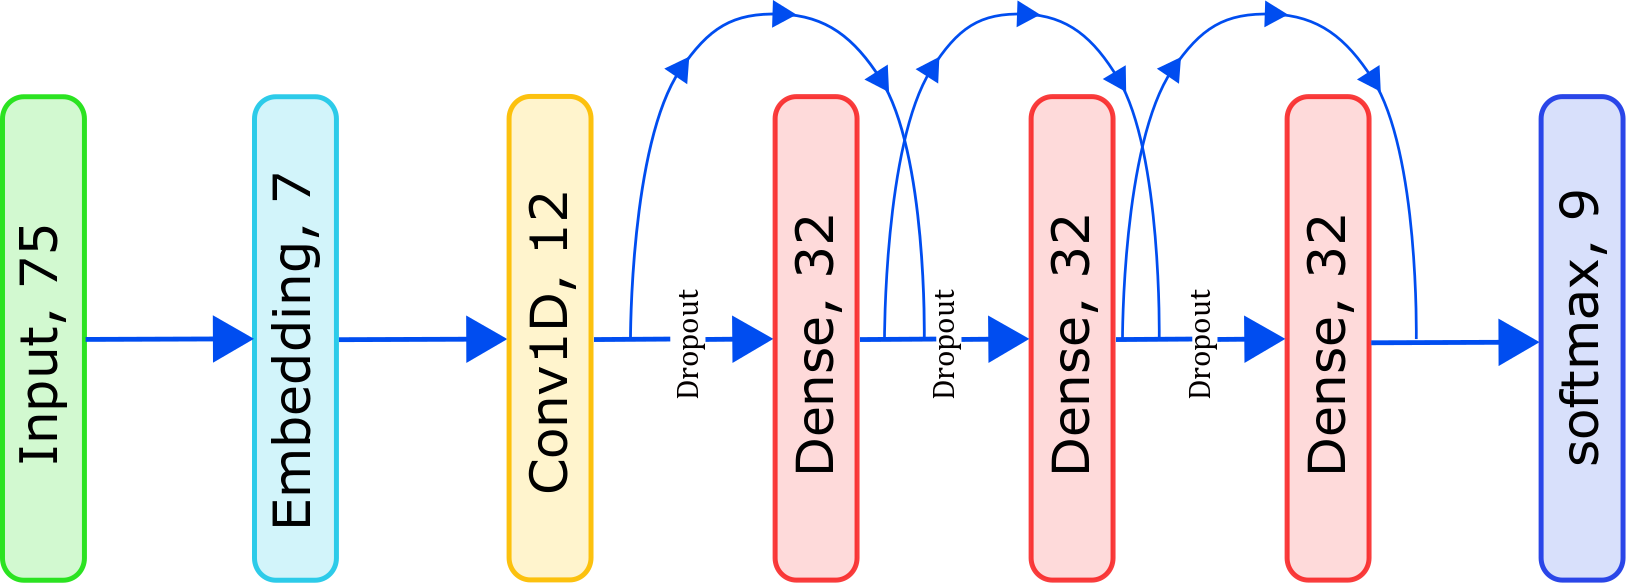

In [1]:
# load pycodestyle-magic to be compliant with PEP8 conventions
%load_ext pycodestyle_magic

In [2]:
# activate pycodestyle for each cell
%pycodestyle_on

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.models import Model

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
targets = pd.get_dummies(train['target'])

In [5]:
cce = tf.keras.losses.CategoricalCrossentropy()
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

In [6]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric',
    min_delta=1e-05,
    patience=8,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric',
    factor=0.7,
    patience=2,
    verbose=0,
    mode='min')

In [30]:
def conv_model():

    conv_inputs = layers.Input(shape=(75))
    # Embedding layers
    embed = layers.Embedding(
        input_dim=354, 
        output_dim=7,
        embeddings_regularizer='l2')(conv_inputs)
    # Convolution layers
    embed = layers.Conv1D(
        12,
        1,
        activation='relu')(embed) 
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    # Residual blocks layers
    hidden = tfa.layers.WeightNormalization(layers.Dense(
        units=32,
        activation='selu',
        kernel_initializer="lecun_normal"))(hidden)
    drop1 = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    hidden2 = tfa.layers.WeightNormalization(layers.Dense(
        units=32,
        activation='relu',
        kernel_initializer="lecun_normal"))(drop1) 
    drop2 = layers.Dropout(0.4)(layers.Concatenate()([hidden, hidden2]))
    hidden3 = tfa.layers.WeightNormalization(layers.Dense(
        units=32, 
        activation='elu',
        kernel_initializer="lecun_normal"))(drop2)
    output = layers.Concatenate()([hidden2, hidden3])
    # Final layer
    conv_outputs = layers.Dense(
        units=9, 
        activation='softmax',
        kernel_initializer="lecun_normal")(output)
    # Model instantiation
    model = Model(conv_inputs,conv_outputs)
    return model

In [31]:
model = conv_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 7)        2478        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 75, 12)       96          embedding_1[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 900)          0           conv1d_1[0][0]                   
____________________________________________________________________________________________

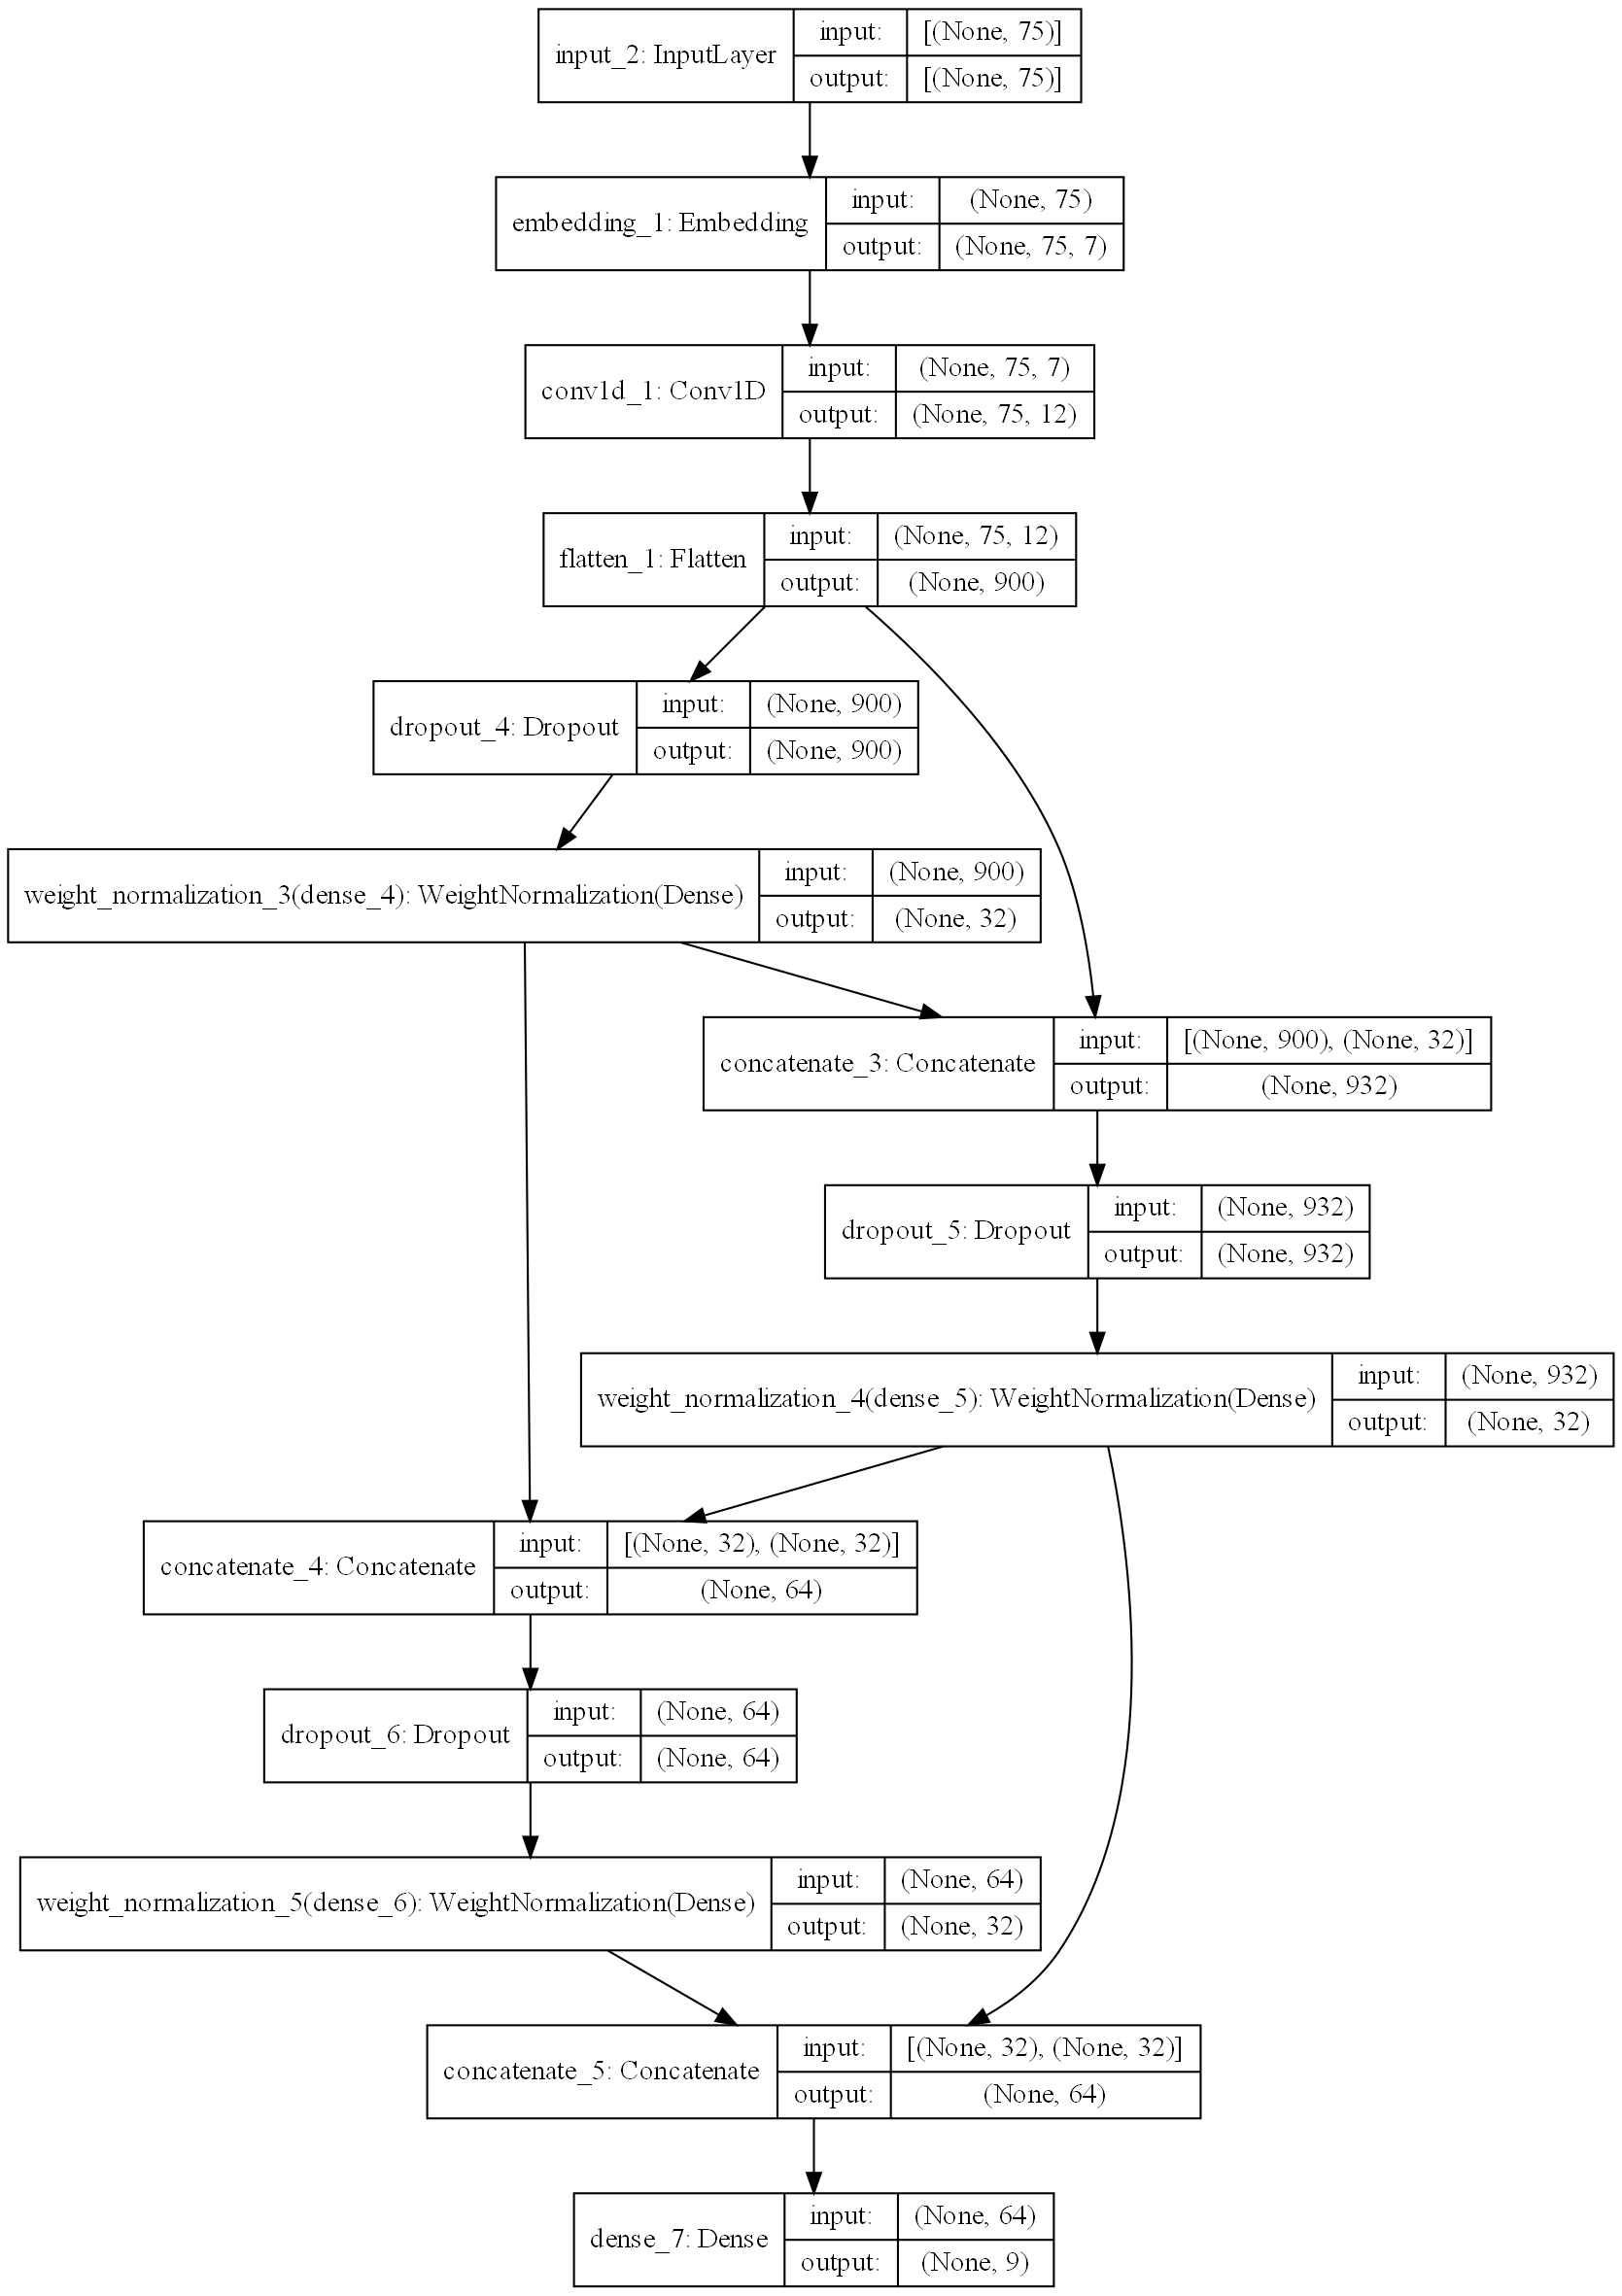

In [32]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    rankdir='TB',
    dpi=150)

In [33]:
%%time
oof_NN = np.zeros((train.shape[0], 9))
pred_NN = np.zeros((test.shape[0], 9))
N_FOLDS = 25
SEED = 42
EPOCH = 70
skf = StratifiedKFold(
    n_splits=N_FOLDS, 
    shuffle=True,
    random_state=SEED)
for fold, (tr_idx, ts_idx) in enumerate(skf.split(train, train.iloc[:, -1])):
    print(f"\n ====== TRAINING FOLD {fold} =======\n")
    X_train = train.iloc[:, 1:-1].iloc[tr_idx]
    y_train = targets.iloc[tr_idx]
    X_test = train.iloc[:, 1:-1].iloc[ts_idx]
    y_test = targets.iloc[ts_idx]
    K.clear_session()
    # NN CONV MODEL training
    print("\n-----Convolution model Training----\n")
    model_conv = conv_model()
    model_conv.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        metrics=custom_metric)
    model_conv.fit(
        X_train,
        y_train,
        batch_size=256,
        epochs=EPOCH,
        validation_data=(X_test, y_test),
        callbacks=[es, plateau],
        verbose=0)
    # Convolution Model prediction
    pred = model_conv.predict(X_test)
    oof_NN[ts_idx] += pred
    score_NN = log_loss(y_test, pred)
    print(f"\nFOLD {fold} Score convolution model: {score_NN}\n")
    pred_NN += model_conv.predict(test.iloc[:, 1:])/N_FOLDS
score = log_loss(targets, oof_NN)
print(f"\n=== FINAL SCORE CONVOLUTION MODEL : {score}===\n")


 ====== TRAINING FOLD 0 =======


-----Convolution model Training----


FOLD 0 Score convolution model: 1.7454754151809029


 ====== TRAINING FOLD 1 =======


-----Convolution model Training----


FOLD 1 Score convolution model: 1.749645558688324


 ====== TRAINING FOLD 2 =======


-----Convolution model Training----


FOLD 2 Score convolution model: 1.7416488098267


 ====== TRAINING FOLD 3 =======


-----Convolution model Training----


FOLD 3 Score convolution model: 1.7491721279988997


 ====== TRAINING FOLD 4 =======


-----Convolution model Training----


FOLD 4 Score convolution model: 1.7460565044768155


 ====== TRAINING FOLD 5 =======


-----Convolution model Training----


FOLD 5 Score convolution model: 1.7375132815830876


 ====== TRAINING FOLD 6 =======


-----Convolution model Training----


FOLD 6 Score convolution model: 1.7320390558196233


 ====== TRAINING FOLD 7 =======


-----Convolution model Training----


FOLD 7 Score convolution model: 1.7423795241469051


 ==

In [34]:
pred_embedding = pred_NN

In [35]:
submission = pd.read_csv("sample_submission.csv")
for i in range(9):
    submission[f'Class_{i+1}'] = pred_embedding[:, i]
submission.to_csv("Purchot_neural_network_modified_residuals.csv", index=False)